# Colab Setup

In [ ]:
!pip install diffusers==0.4.2
!pip install transformers==4.23.1
!pip install scipy==1.9.2
!pip install ftfy==6.1.1
!pip install ipywidgets==7.7.2

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# Hugging face login

If you have not create an account with hugging face and get a write token here 

Also make sure you come to here https://huggingface.co/CompVis/stable-diffusion-v1-4 and accept the condition to access the repo

In [1]:
from huggingface_hub import notebook_login

notebook_login()

# Txt2Img Pipeline

set up device

In [2]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

Load in all the components

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

load scheduler

In [6]:
from diffusers import LMSDiscreteScheduler, DDIMScheduler, PNDMScheduler

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
# scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
# scheduler = PNDMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

map to device

In [7]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

**Configuration here**

In [98]:
prompt = ["Boba"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

quick run 

  0%|          | 0/100 [00:00<?, ?it/s]

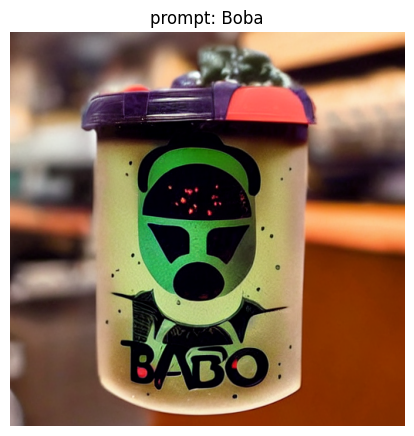

In [105]:
from common.helper import run_stable_diffusion

prompt = ["Boba"]
seed = 32
run_stable_diffusion (prompt, vae=vae, tokenizer=tokenizer, text_encoder=text_encoder, unet=unet, scheduler=scheduler, seed=seed)

Process

In [99]:
# 1 obtain text embeding
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# 2 configure guidance for conditioning the Unet
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)

with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# 3 generate noise
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

# 4 initialize scheduler 
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma

In [100]:
# 5 Forward through Unet
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

In [101]:
# Forward through vae
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample


Visualization

Text(0.5, 1.0, 'prompt: Boba')

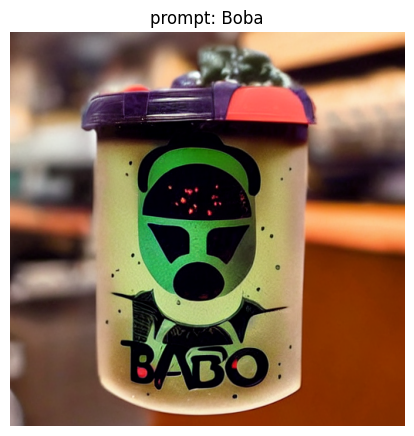

In [102]:
import matplotlib.pyplot as plt 

# normalize back to 0-1
image_norm = (image / 2 + 0.5).clamp(0, 1)
np_image = image_norm.detach().cpu().permute(0, 2, 3, 1).numpy()
np_image = (np_image * 255).round().astype("uint8")

fig = plt.figure(figsize=(height/100, width/100))
ax = fig.add_subplot()
ax.imshow(np_image[0])
ax.axis('off')
ax.set_title(f'prompt: {prompt[0]}')